# 데이터 전처리

## 데이터 불러오기

In [1]:
import glob
import os, re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

In [8]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### 데이터 확인하기
데이터 정제를 위해 훑어본다.  
시작이 괄호거나, 따옴표로 시작하는 문장을 카운트 해본다.

In [9]:
count = 0;
for i, text in enumerate(raw_corpus):
    if len(text) == 0: continue
    if text[0] == '(' or text[0] == '[' or text[0] == '"' or text[0] == "'":
        count += 1
        
print(count)

6294


### ()소괄호, []대괄호, "(큰따옴표) 삭제하기


### 데이터를 토큰화 할수 있게 정재하기

In [10]:
# 1. 공백제거
# 2. 특수문자 양 옆에 공백 넣기
# 3. 여러 공백을 한개의 공백으로
# 4. 문자, 특수문자가 아닌것들을 공백으로
# 5. 좌우 공백 제거
# 6. 문장 양옆에 start , end 토큰 넣기
# 7. 토큰이 15개가 넘어가면 문장 제외하기

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿\)\(\"])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿\)\(\"]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    
    if len(sentence.split()) > 15: # 7
        return None;
    return sentence

corpus = []
for sentence in raw_corpus:
    # 길이가 0이면 pass
    if len(sentence) == 0: continue
        
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # 토큰이 15개가 넘어가서 안나왔으면 pass
    if preprocessed_sentence == None:
        continue
    
    corpus.append(preprocessed_sentence)


In [6]:
print(corpus[:3])
print(len(corpus))

['<start> now i ve heard there was a secret chord <end>', '<start> that david played , and it pleased the lord <end>', '<start> but you don t really care for music , do you ? <end>']
155031


### 토큰화 및 데이터 분리

In [11]:
def tokenize(corpus):
    # tokenizer 설정
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 단어수 12000개
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    # 단어장 만들기
    tokenizer.fit_on_texts(corpus)
    
    # tokenizer를 이용해 tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 시퀀스 길이 일정하게 해주기, 패딩을 붙여 길이를 맞춘다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

In [8]:
print(tensor[:3, :15] )
print(tensor.shape)

[[   2   52    4   97  302   63   54    9  946 6242    3    0    0    0
     0]
 [   2   15 2949  873    5    8   11 5727    6  372    3    0    0    0
     0]
 [   2   35    7   42   16  168  287   30  340    5   49    7   48    3
     0]]
(155031, 15)


In [13]:
# source input
source_input = tensor[:,:-1]
# target output
target_input = tensor[:, 1:]

In [10]:
print(source_input[0])
print(target_input[0])

[   2   52    4   97  302   63   54    9  946 6242    3    0    0    0]
[  52    4   97  302   63   54    9  946 6242    3    0    0    0    0]


### enc(train)과 enc(test)로 데이터 나누기

In [14]:
enc_train, enc_val, dec_train, dec_val = train_test_split(source_input, target_input, 
                                                          test_size=0.2,  
                                                          random_state=34)

In [12]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124024, 14)
Target Train: (124024, 14)


### 데이터 객체 생성

In [15]:
BUFFER_SIZE = len(source_input)
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)) \
                        .shuffle(BUFFER_SIZE) \
                        .batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

# 모델 구성

In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out  


### 3) 모델 학습
이번 Exploration에서 제공한 loss 함수를 사용한다.
Embedding Size와 Hidden Size를 조절해 10 epoch 안에 val_loss값을 2.2수준으로 줄이는 모델을 설계하자!  

val_loss 값을 확인하려면 fit() 파라미터에 validation_data를 넣어주어야 한다.

### embedding_size = 256, hidden_size = 1024

In [47]:
embedding_size = 256
hidden_size = 1024
model1 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [48]:
# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model1(src_sample)
model1.summary()

Model: "text_generator_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_10 (LSTM)               multiple                  5246976   
_________________________________________________________________
lstm_11 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_5 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [51]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model1.compile(loss=loss, optimizer=optimizer)
history1 = model1.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 101s 204ms/step - loss: 3.1953 - val_loss: 2.9898
Epoch 2/10
484/484 [==============================] - 99s 204ms/step - loss: 2.8190 - val_loss: 2.7897
Epoch 3/10
484/484 [==============================] - 99s 204ms/step - loss: 2.5948 - val_loss: 2.6697
Epoch 4/10
484/484 [==============================] - 99s 205ms/step - loss: 2.4036 - val_loss: 2.5801
Epoch 5/10
484/484 [==============================] - 99s 204ms/step - loss: 2.2348 - val_loss: 2.5144
Epoch 6/10
484/484 [==============================] - 99s 203ms/step - loss: 2.0841 - val_loss: 2.4618
Epoch 7/10
484/484 [==============================] - 99s 205ms/step - loss: 1.9486 - val_loss: 2.4213
Epoch 8/10
484/484 [==============================] - 99s 204ms/step - loss: 1.8261 - val_loss: 2.3917
Epoch 9/10
484/484 [==============================] - 99s 205ms/step - loss: 1.7146 - val_loss: 2.3681
Epoch 10/10
484/484 [==============================] - 99s 204ms/step - 

990.9419877529144 sec


<function matplotlib.pyplot.show(close=None, block=None)>

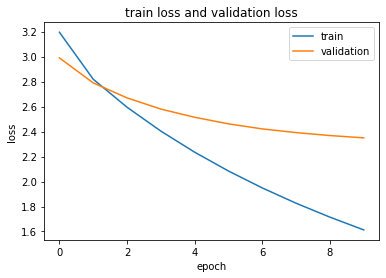

In [53]:
print("{} sec".format(end - start))

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### embedding_size = 512 hidden_size = 1024

In [54]:
embedding_size = 512
hidden_size = 1024
model2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [55]:
# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model2(src_sample)
model2.summary()

Model: "text_generator_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  6295552   
_________________________________________________________________
lstm_13 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_6 (Dense)              multiple                  12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________


In [56]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model2.compile(loss=loss, optimizer=optimizer)
history2 = model2.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 105s 212ms/step - loss: 3.4515 - val_loss: 3.1422
Epoch 2/10
484/484 [==============================] - 103s 213ms/step - loss: 2.9924 - val_loss: 2.9426
Epoch 3/10
484/484 [==============================] - 103s 213ms/step - loss: 2.8092 - val_loss: 2.8210
Epoch 4/10
484/484 [==============================] - 103s 212ms/step - loss: 2.6735 - val_loss: 2.7379
Epoch 5/10
484/484 [==============================] - 103s 212ms/step - loss: 2.5567 - val_loss: 2.6732
Epoch 6/10
484/484 [==============================] - 103s 213ms/step - loss: 2.4507 - val_loss: 2.6236
Epoch 7/10
484/484 [==============================] - 103s 213ms/step - loss: 2.3533 - val_loss: 2.5769
Epoch 8/10
484/484 [==============================] - 103s 213ms/step - loss: 2.2616 - val_loss: 2.5376
Epoch 9/10
484/484 [==============================] - 103s 213ms/step - loss: 2.1752 - val_loss: 2.5080
Epoch 10/10
484/484 [==============================] - 103s 213m

1032.9228966236115 sec


<function matplotlib.pyplot.show(close=None, block=None)>

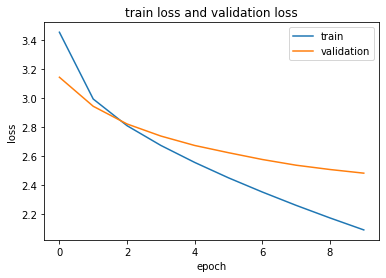

In [57]:
print("{} sec".format(end - start))

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### embedding_size = 512 hidden_size = 2048

In [58]:
embedding_size = 512
hidden_size = 2048
model3 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [59]:
# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model3(src_sample)
model3.summary()

Model: "text_generator_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_14 (LSTM)               multiple                  20979712  
_________________________________________________________________
lstm_15 (LSTM)               multiple                  33562624  
_________________________________________________________________
dense_7 (Dense)              multiple                  24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________


In [60]:
import time

start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model3.compile(loss=loss, optimizer=optimizer)
history3 = model3.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 279s 572ms/step - loss: 3.3815 - val_loss: 3.0246
Epoch 2/10
484/484 [==============================] - 277s 573ms/step - loss: 2.8459 - val_loss: 2.7898
Epoch 3/10
484/484 [==============================] - 277s 573ms/step - loss: 2.5957 - val_loss: 2.6375
Epoch 4/10
484/484 [==============================] - 278s 574ms/step - loss: 2.3653 - val_loss: 2.5155
Epoch 5/10
484/484 [==============================] - 278s 574ms/step - loss: 2.1438 - val_loss: 2.4169
Epoch 6/10
484/484 [==============================] - 278s 574ms/step - loss: 1.9329 - val_loss: 2.3424
Epoch 7/10
484/484 [==============================] - 278s 574ms/step - loss: 1.7320 - val_loss: 2.2828
Epoch 8/10
484/484 [==============================] - 278s 573ms/step - loss: 1.5458 - val_loss: 2.2428
Epoch 9/10
484/484 [==============================] - 278s 574ms/step - loss: 1.3817 - val_loss: 2.2158
Epoch 10/10
484/484 [==============================] - 278s 573m

2777.9640583992004 sec


<function matplotlib.pyplot.show(close=None, block=None)>

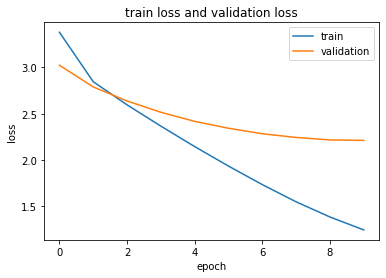

In [61]:
print("{} sec".format(end - start))

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

embedding_size만 2배 늘렸을땐 train_loss와 val_loss의 격차가 이전에 비해서 조금 줄어들었다.  
하지만 embedding_size와 hidden_size를 각각 2배 늘린 모델에선 loss의 격차가 다시 늘어났다.  
embedding_size, hidden_size를 무작정 늘린다고 모델이 좋아지는 것은 아니라고 생각했다.  
시간은 990, 1030, 2770 sec로 점점 시간이 너무 늘어났고, 마지막 모델은 시간에 비해 성능이 제대로 나오지 않은 모습을 보인다.  
인터넷에 찾아보니 lstm을 개선한 gru로 바꾸면 성능이 좀 괜찮아 진다고해서 한번 바꿔 보았따.

## 모델 바꿔보기 LSTM -> GRU
LSTM의 구조를 간소화해 성능을 향상시킨 모델이라고 한다.

In [4]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out  

In [19]:
embedding_size = 256
hidden_size = 1024
model4 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [20]:
# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model4(src_sample)
model4.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
gru_2 (GRU)                  multiple                  3938304   
_________________________________________________________________
gru_3 (GRU)                  multiple                  6297600   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 25,609,185
Trainable params: 25,609,185
Non-trainable params: 0
_________________________________________________________________


In [22]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model4.compile(loss=loss, optimizer=optimizer)
history4 = model4.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 77s 156ms/step - loss: 3.4074 - val_loss: 3.0237
Epoch 2/10
484/484 [==============================] - 78s 161ms/step - loss: 2.8498 - val_loss: 2.7923
Epoch 3/10
484/484 [==============================] - 78s 161ms/step - loss: 2.6059 - val_loss: 2.6570
Epoch 4/10
484/484 [==============================] - 78s 161ms/step - loss: 2.4055 - val_loss: 2.5652
Epoch 5/10
484/484 [==============================] - 78s 160ms/step - loss: 2.2345 - val_loss: 2.4975
Epoch 6/10
484/484 [==============================] - 78s 160ms/step - loss: 2.0848 - val_loss: 2.4437
Epoch 7/10
484/484 [==============================] - 78s 160ms/step - loss: 1.9514 - val_loss: 2.4049
Epoch 8/10
484/484 [==============================] - 78s 161ms/step - loss: 1.8296 - val_loss: 2.3718
Epoch 9/10
484/484 [==============================] - 78s 161ms/step - loss: 1.7187 - val_loss: 2.3522
Epoch 10/10
484/484 [==============================] - 78s 161ms/step - l

778.4752266407013 sec


<function matplotlib.pyplot.show(close=None, block=None)>

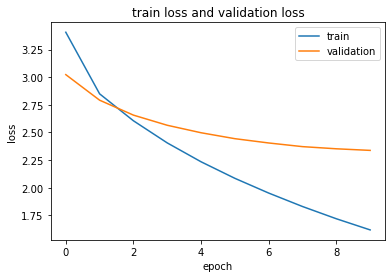

In [23]:
print("{} sec".format(end - start))

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### embedding_size = 512, hidden_size = 1024

In [28]:
embedding_size = 512
hidden_size = 1024
model5 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [29]:
# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model5(src_sample)
model5.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  6144512   
_________________________________________________________________
gru_6 (GRU)                  multiple                  4724736   
_________________________________________________________________
gru_7 (GRU)                  multiple                  6297600   
_________________________________________________________________
dense_3 (Dense)              multiple                  12301025  
Total params: 29,467,873
Trainable params: 29,467,873
Non-trainable params: 0
_________________________________________________________________


In [30]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model5.compile(loss=loss, optimizer=optimizer)
history5 = model5.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 80s 162ms/step - loss: 3.2577 - val_loss: 2.8766
Epoch 2/10
484/484 [==============================] - 81s 167ms/step - loss: 2.6729 - val_loss: 2.6281
Epoch 3/10
484/484 [==============================] - 81s 166ms/step - loss: 2.3626 - val_loss: 2.4880
Epoch 4/10
484/484 [==============================] - 81s 166ms/step - loss: 2.1105 - val_loss: 2.3959
Epoch 5/10
484/484 [==============================] - 81s 166ms/step - loss: 1.9012 - val_loss: 2.3350
Epoch 6/10
484/484 [==============================] - 81s 166ms/step - loss: 1.7234 - val_loss: 2.2959
Epoch 7/10
484/484 [==============================] - 81s 166ms/step - loss: 1.5717 - val_loss: 2.2757
Epoch 8/10
484/484 [==============================] - 81s 167ms/step - loss: 1.4432 - val_loss: 2.2657
Epoch 9/10
484/484 [==============================] - 81s 166ms/step - loss: 1.3362 - val_loss: 2.2688
Epoch 10/10
484/484 [==============================] - 81s 166ms/step - l

806.5143747329712 sec


<function matplotlib.pyplot.show(close=None, block=None)>

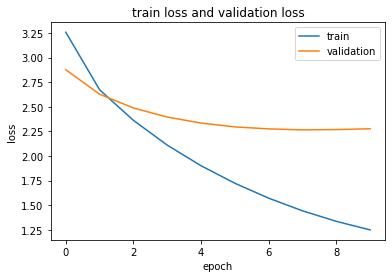

In [34]:
print("{} sec".format(end - start))

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### 모델을 바꾼 후
모델을 학습하는 속도는 조금 빨라졌지만 성능에는 큰 영향을 주지 않는듯 하다.

### 모델이 과적합이 되서 val_loss 가 목표치에 도달을 못하는건가?
dropout을 적용해 과적합 되는걸 방지해보자.


In [46]:
class TextGeneratorPlusDropout(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.linear(out)
        
        return out  

In [48]:
embedding_size = 512
hidden_size = 1024
model6 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model6(src_sample)
model6.summary()

Model: "text_generator_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     multiple                  6144512   
_________________________________________________________________
gru_48 (GRU)                 multiple                  4724736   
_________________________________________________________________
gru_49 (GRU)                 multiple                  6297600   
_________________________________________________________________
dense_24 (Dense)             multiple                  12301025  
Total params: 29,467,873
Trainable params: 29,467,873
Non-trainable params: 0
_________________________________________________________________


In [50]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model6.compile(loss=loss, optimizer=optimizer)
history6 = model6.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 92s 185ms/step - loss: 3.3210 - val_loss: 2.9341
Epoch 2/10
484/484 [==============================] - 89s 184ms/step - loss: 2.7499 - val_loss: 2.7034
Epoch 3/10
484/484 [==============================] - 89s 184ms/step - loss: 2.4806 - val_loss: 2.5679
Epoch 4/10
484/484 [==============================] - 89s 183ms/step - loss: 2.2584 - val_loss: 2.4743
Epoch 5/10
484/484 [==============================] - 89s 183ms/step - loss: 2.0696 - val_loss: 2.4049
Epoch 6/10
484/484 [==============================] - 89s 183ms/step - loss: 1.9053 - val_loss: 2.3609
Epoch 7/10
484/484 [==============================] - 89s 183ms/step - loss: 1.7608 - val_loss: 2.3242
Epoch 8/10
484/484 [==============================] - 89s 183ms/step - loss: 1.6320 - val_loss: 2.3025
Epoch 9/10
484/484 [==============================] - 89s 183ms/step - loss: 1.5178 - val_loss: 2.2868
Epoch 10/10
484/484 [==============================] - 89s 183ms/step - l

890.6639084815979 sec


<function matplotlib.pyplot.show(close=None, block=None)>

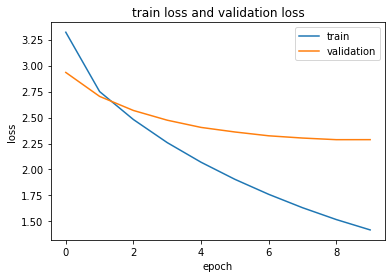

In [52]:
print("{} sec".format(end - start))

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### 히든 사이즈를 좀더 늘려보자

In [54]:
embedding_size = 512
hidden_size = 1600
model7 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model7(src_sample)
model7.summary()

Model: "text_generator_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     multiple                  6144512   
_________________________________________________________________
gru_52 (GRU)                 multiple                  10147200  
_________________________________________________________________
gru_53 (GRU)                 multiple                  15369600  
_________________________________________________________________
dense_26 (Dense)             multiple                  19213601  
Total params: 50,874,913
Trainable params: 50,874,913
Non-trainable params: 0
_________________________________________________________________


In [56]:
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model7.compile(loss=loss, optimizer=optimizer)
history7 = model7.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
484/484 [==============================] - 177s 362ms/step - loss: 3.1760 - val_loss: 2.8159
Epoch 2/10
484/484 [==============================] - 174s 360ms/step - loss: 2.5783 - val_loss: 2.5297
Epoch 3/10
484/484 [==============================] - 175s 361ms/step - loss: 2.1764 - val_loss: 2.3668
Epoch 4/10
484/484 [==============================] - 175s 361ms/step - loss: 1.8371 - val_loss: 2.2852
Epoch 5/10
484/484 [==============================] - 175s 362ms/step - loss: 1.5797 - val_loss: 2.2396
Epoch 6/10
484/484 [==============================] - 175s 361ms/step - loss: 1.3859 - val_loss: 2.2288
Epoch 7/10
484/484 [==============================] - 175s 362ms/step - loss: 1.2441 - val_loss: 2.2404
Epoch 8/10
484/484 [==============================] - 175s 362ms/step - loss: 1.1480 - val_loss: 2.2664
Epoch 9/10
484/484 [==============================] - 175s 361ms/step - loss: 1.0868 - val_loss: 2.2923
Epoch 10/10
484/484 [==============================] - 175s 361m

1751.0775990486145 sec


<function matplotlib.pyplot.show(close=None, block=None)>

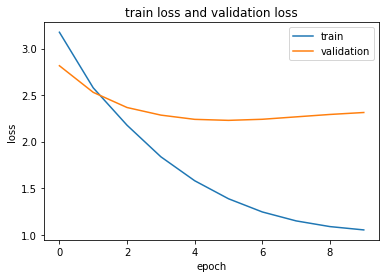

In [57]:
print("{} sec".format(end - start))

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

## 모델 변경 및 파리미터 수정을 해봤지만 2.2 도달을 하지 못했다!
전처리 단계에서 문제가 있지 않을까 생각해 다시한번 살펴 보기로 했다.  
단어가 한개인 경우는 문장 생성에 도움을 주지 않을듯해서 삭제 해보기로 했다.

In [61]:
count = 0
for text in corpus:
    if len(text.split()) < 4:
        count += 1
    
count

2190

In [157]:
corpus_rm_one_word = corpus.copy()
rm_dict = {}

for text in corpus_rm_one_word:
    if len(text.split()) < 4:
        rm_text = text.split()[1]
        
        if rm_dict.get(rm_text) == None:
            rm_dict.setdefault(rm_text, int(1))
        else:
            rm_dict[rm_text] = rm_dict[rm_text] + 1

In [158]:
rm_dict

{'hallelujah': 33,
 'nevermind': 4,
 'amen': 10,
 'argument': 1,
 'started': 8,
 'yes': 5,
 'chorus': 202,
 'cmon': 4,
 'alright': 15,
 'ov': 2,
 'who': 3,
 'caller': 6,
 'hello': 3,
 'yo': 4,
 'shit': 4,
 'intro': 11,
 'ai': 2,
 'santana': 2,
 'outro': 8,
 'assholes': 2,
 'yeah': 110,
 'verse': 43,
 'ya': 5,
 'gone': 2,
 'bridge': 27,
 'hook': 15,
 'mario': 2,
 'chrous': 2,
 'bass': 5,
 'honey': 2,
 'yeahchainz': 2,
 'tunechi': 4,
 'nikki': 3,
 'wayne': 2,
 'weezy': 4,
 'i': 9,
 'tpain': 2,
 'wasnt': 2,
 'fustin': 2,
 'puffin': 2,
 'drake': 2,
 'tyga': 2,
 'young': 2,
 'streets': 2,
 'aye': 2,
 'ok': 6,
 'bitch': 2,
 'aha': 2,
 'cole': 2,
 'hey': 27,
 'currency': 2,
 'wow': 2,
 'now': 7,
 'bg': 2,
 'what': 2,
 'tanto': 2,
 'motherfuckin': 2,
 'nothin': 4,
 'mcdonalds': 2,
 'eastside': 2,
 'always': 9,
 'tonight': 13,
 'again': 2,
 'whoa': 6,
 'badlands': 5,
 'freehold': 1,
 'fire': 4,
 'hah': 4,
 'uh': 15,
 'whoh': 2,
 'dippin': 2,
 'benjamins': 2,
 'uhh': 4,
 'notorious': 4,
 'capich

In [161]:
from tqdm import tqdm

cnt = 0
for rm_text in tqdm(rm_dict.keys()):
    rm_corpus = '<start> ' + rm_text + ' <end>'
    corpus_rm_one_word = list([value for value in corpus_rm_one_word if not(value == rm_corpus)])
            
len(corpus_rm_one_word)

100%|██████████| 614/614 [00:05<00:00, 102.34it/s]


152891

In [162]:
count = 0
for text in corpus_rm_one_word:
    if len(text.split()) < 4:
        print(text)
        count += 1
    
print(count)

<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
<start>  <end>
50


In [155]:
# 나머지 빈 값도 삭제
corpus_rm_one_word = list([value for value in corpus_rm_one_word if not(value == '<start>  <end>')])

In [163]:
print(len(corpus))
print(len(corpus_rm_one_word))

155031
152891


### 다시 토큰화부터 진행

In [164]:
tensor, tokenizer = tokenize(corpus_rm_one_word)

In [165]:
# source input
source_input = tensor[:,:-1]
# target output
target_input = tensor[:, 1:]

In [166]:
# 데이터 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(source_input, target_input, 
                                                          test_size=0.2,  
                                                          random_state=34)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (122312, 14)
Target Train: (122312, 14)


In [167]:
# 데이터셋 만들기
BUFFER_SIZE = len(source_input)
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)) \
                        .shuffle(BUFFER_SIZE) \
                        .batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [168]:
# 모델 정의
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.3)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.linear(out)
        
        return out

In [169]:
# 모델 파라미터 및 모델 생성
embedding_size = 256
hidden_size = 1024
model8 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model8(src_sample)
model8.summary()

Model: "text_generator_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     multiple                  3072256   
_________________________________________________________________
gru_54 (GRU)                 multiple                  3938304   
_________________________________________________________________
gru_55 (GRU)                 multiple                  6297600   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_27 (Dense)             multiple                  12301025  
Total params: 25,609,185
Trainable params: 25,609,185
Non-trainable params: 0
_________________________________________________________________


In [170]:
# 학습
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model8.compile(loss=loss, optimizer=optimizer)
history8 = model8.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
477/477 [==============================] - 77s 157ms/step - loss: 3.4229 - val_loss: 2.9934
Epoch 2/10
477/477 [==============================] - 79s 165ms/step - loss: 2.8679 - val_loss: 2.7564
Epoch 3/10
477/477 [==============================] - 82s 171ms/step - loss: 2.6287 - val_loss: 2.6140
Epoch 4/10
477/477 [==============================] - 83s 174ms/step - loss: 2.4347 - val_loss: 2.5180
Epoch 5/10
477/477 [==============================] - 84s 176ms/step - loss: 2.2764 - val_loss: 2.4476
Epoch 6/10
477/477 [==============================] - 85s 177ms/step - loss: 2.1429 - val_loss: 2.3933
Epoch 7/10
477/477 [==============================] - 85s 177ms/step - loss: 2.0280 - val_loss: 2.3510
Epoch 8/10
477/477 [==============================] - 85s 178ms/step - loss: 1.9269 - val_loss: 2.3145
Epoch 9/10
477/477 [==============================] - 85s 178ms/step - loss: 1.8364 - val_loss: 2.2919
Epoch 10/10
477/477 [==============================] - 85s 178ms/step - l

157.7105348110199 sec


<function matplotlib.pyplot.show(close=None, block=None)>

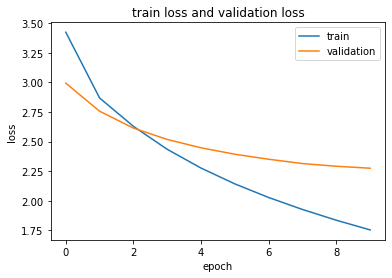

In [184]:
# 결과
print("{} sec".format(end - start))

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

## 그래도 전처리를 하니 val_loss가 유의미하게 줄어들었다.
embedding_size와 hidden_size를 좀더 늘려보자

In [172]:
# 모델 파라미터 및 모델 생성
embedding_size = 384
hidden_size = 1536
model9 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model9(src_sample)
model9.summary()

Model: "text_generator_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     multiple                  4608384   
_________________________________________________________________
gru_56 (GRU)                 multiple                  8856576   
_________________________________________________________________
gru_57 (GRU)                 multiple                  14164992  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_28 (Dense)             multiple                  18445537  
Total params: 46,075,489
Trainable params: 46,075,489
Non-trainable params: 0
_________________________________________________________________


In [173]:
# 학습
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model9.compile(loss=loss, optimizer=optimizer)
history9 = model9.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

end = time.time()

Epoch 1/10
477/477 [==============================] - 153s 316ms/step - loss: 3.2898 - val_loss: 2.8820
Epoch 2/10
477/477 [==============================] - 156s 328ms/step - loss: 2.7199 - val_loss: 2.6053
Epoch 3/10
477/477 [==============================] - 156s 327ms/step - loss: 2.3965 - val_loss: 2.4393
Epoch 4/10
477/477 [==============================] - 156s 327ms/step - loss: 2.1216 - val_loss: 2.3344
Epoch 5/10
477/477 [==============================] - 156s 327ms/step - loss: 1.8985 - val_loss: 2.2650
Epoch 6/10
477/477 [==============================] - 156s 327ms/step - loss: 1.7194 - val_loss: 2.2233
Epoch 7/10
477/477 [==============================] - 156s 327ms/step - loss: 1.5727 - val_loss: 2.1994
Epoch 8/10
477/477 [==============================] - 156s 327ms/step - loss: 1.4575 - val_loss: 2.1934
Epoch 9/10
477/477 [==============================] - 156s 328ms/step - loss: 1.3674 - val_loss: 2.2002
Epoch 10/10
477/477 [==============================] - 156s 328m

157.7105348110199 sec


<function matplotlib.pyplot.show(close=None, block=None)>

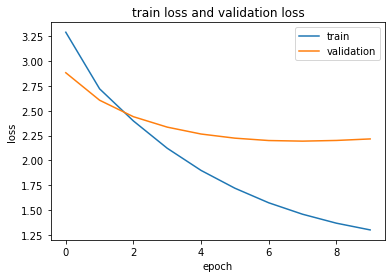

In [185]:
# 결과
print("{} sec".format(end - start))

plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### epoch 8에서 목표치를 달성했지만! epoch9로 넘어가면서 val_loss가 다시 증가하였다! 과적합이라고 판단되서  val_loss 값이 더이상 줄어들지 않는다면 종료해보자!
callback 함수 적용!

In [189]:
# 모델 파라미터 및 모델 생성
embedding_size = 384
hidden_size = 1536
model10 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model10(src_sample)
model10.summary()

Model: "text_generator_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     multiple                  3072256   
_________________________________________________________________
gru_60 (GRU)                 multiple                  8266752   
_________________________________________________________________
gru_61 (GRU)                 multiple                  14164992  
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                  18445537  
Total params: 43,949,537
Trainable params: 43,949,537
Non-trainable params: 0
_________________________________________________________________


In [191]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


# 학습
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

# callback 함수 정의
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2, 
                               verbose=1)

model10.compile(loss=loss, optimizer=optimizer)
history10 = model10.fit(dataset, 
                        epochs=10, 
                        validation_data = (enc_val, dec_val),
                       callbacks=[early_stopping])

end = time.time()

Epoch 1/10
477/477 [==============================] - 156s 323ms/step - loss: 2.4922 - val_loss: 2.4915
Epoch 2/10
477/477 [==============================] - 153s 320ms/step - loss: 2.2048 - val_loss: 2.3664
Epoch 3/10
477/477 [==============================] - 153s 321ms/step - loss: 1.9740 - val_loss: 2.2971
Epoch 4/10
477/477 [==============================] - 153s 321ms/step - loss: 1.7909 - val_loss: 2.2494
Epoch 5/10
477/477 [==============================] - 153s 320ms/step - loss: 1.6440 - val_loss: 2.2292
Epoch 6/10
477/477 [==============================] - 153s 320ms/step - loss: 1.5248 - val_loss: 2.2147
Epoch 7/10
477/477 [==============================] - 154s 322ms/step - loss: 1.4300 - val_loss: 2.2103
Epoch 8/10
477/477 [==============================] - 152s 319ms/step - loss: 1.3549 - val_loss: 2.2260
Epoch 9/10
477/477 [==============================] - 153s 321ms/step - loss: 1.2986 - val_loss: 2.2338
Epoch 00009: early stopping


### earlystopping을 이용해서 과적합을 막는것은 좋았으나,  종료된 시점에서 최고의 성능이(epoch 7) 리턴되는게 아닌 (epoch9)가 리턴이 된다.
이를 보완하기 위해 ModelCheckpoint를 활용해보자

In [199]:
# 모델 파라미터 및 모델 생성
embedding_size = 384
hidden_size = 1536
model12 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model12(src_sample)
model12.summary()

Model: "text_generator_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     multiple                  4608384   
_________________________________________________________________
gru_64 (GRU)                 multiple                  8856576   
_________________________________________________________________
gru_65 (GRU)                 multiple                  14164992  
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_32 (Dense)             multiple                  18445537  
Total params: 46,075,489
Trainable params: 46,075,489
Non-trainable params: 0
_________________________________________________________________


In [200]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


# 학습
start = time.time()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# optimizer
optimizer = tf.keras.optimizers.Adam()

model_path = os.getenv('HOME')+'/aiffel/NLP/model11/checkpoint'

# callback 함수 정의
mc =ModelCheckpoint(filepath=model_path,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True)

model12.compile(loss=loss, optimizer=optimizer)
history12 = model12.fit(dataset, 
                        epochs=10, 
                        validation_data = (enc_val, dec_val),
                        callbacks=[mc])

end = time.time()

Epoch 1/10
477/477 [==============================] - 158s 327ms/step - loss: 3.2894 - val_loss: 2.8866
Epoch 2/10
477/477 [==============================] - 156s 327ms/step - loss: 2.7261 - val_loss: 2.6100
Epoch 3/10
477/477 [==============================] - 156s 327ms/step - loss: 2.4028 - val_loss: 2.4450
Epoch 4/10
477/477 [==============================] - 156s 327ms/step - loss: 2.1297 - val_loss: 2.3351
Epoch 5/10
477/477 [==============================] - 156s 327ms/step - loss: 1.9075 - val_loss: 2.2690
Epoch 6/10
477/477 [==============================] - 156s 327ms/step - loss: 1.7268 - val_loss: 2.2232
Epoch 7/10
477/477 [==============================] - 156s 327ms/step - loss: 1.5813 - val_loss: 2.2053
Epoch 8/10
477/477 [==============================] - 156s 327ms/step - loss: 1.4644 - val_loss: 2.1950
Epoch 9/10
477/477 [==============================] - 156s 327ms/step - loss: 1.3729 - val_loss: 2.1976
Epoch 10/10
477/477 [==============================] - 156s 327m

1603.9639167785645 sec


<function matplotlib.pyplot.show(close=None, block=None)>

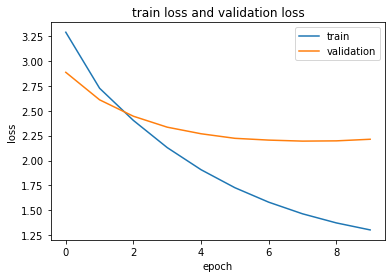

In [202]:
# 결과
print("{} sec".format(end - start))

plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

In [203]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [204]:
generate_text(model12, tokenizer, init_sentence="<start> he")

'<start> he s a walker in the rain <end> '

In [205]:
generate_text(model12, tokenizer, init_sentence="<start> i love")

'<start> i love you so , <end> '

In [206]:
generate_text(model12, tokenizer, init_sentence="<start> babe")

'<start> babe , i m leavin you <end> '

In [207]:
generate_text(model12, tokenizer, init_sentence="<start> why")

'<start> why you wanna get with me <end> '

In [208]:
generate_text(model12, tokenizer, init_sentence="<start> over the")

'<start> over the mountains , across the sky <end> '

In [209]:
generate_text(model12, tokenizer, init_sentence="<start> feeling")

'<start> feeling like i run this whole block . <end> '

In [210]:
generate_text(model12, tokenizer, init_sentence="<start> for")

'<start> for the living <end> '

In [211]:
generate_text(model12, tokenizer, init_sentence="<start> by")

'<start> by the time i m out the door <end> '

### 모델 불러와서 사용해보기

In [212]:
# 모델 파라미터 및 모델 생성
embedding_size = 384
hidden_size = 1536
model13 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러와서, 데이터 모델에 넣는다.
for src_sample, tgt_sample in dataset.take(1): break
model13(src_sample)
model13.summary()

Model: "text_generator_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     multiple                  4608384   
_________________________________________________________________
gru_66 (GRU)                 multiple                  8856576   
_________________________________________________________________
gru_67 (GRU)                 multiple                  14164992  
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_33 (Dense)             multiple                  18445537  
Total params: 46,075,489
Trainable params: 46,075,489
Non-trainable params: 0
_________________________________________________________________


### 가중치로 저장한 모델을 다시 불러올때는 complie을 다시 해줘야 평가가 제대로 된다.
model12는 마지막 epoch10에서 loss가 올라간 상태로 학습이 끝났기 때문에 아래와 같은 모습을 보여주고,  
model13은 최적의 loss가 나온 epoch에서 저장한 모델을 불러와서 아래와같은 모습을 보여주었다.

In [230]:
model12.evaluate(enc_val, dec_val)

956/956 [==============================] - 16s 16ms/step - loss: 2.2137


2.2136943340301514

In [227]:
model_load_path = os.getenv('HOME')+'/aiffel/NLP/model11/checkpoint'

model13.load_weights(model_load_path)
model13.compile(loss=loss, optimizer=optimizer)

In [229]:
model13.evaluate(enc_val, dec_val)

956/956 [==============================] - 16s 16ms/step - loss: 2.1950


2.195024013519287

## 회고  
### 시행착오
이번 exploration에서는 전체적으로 10epoch 모델 학습 시간이 10분~30분이라 시간이 좀 걸렸다.  
이전 exploration에서 했던것과 같이 처음에는 파라미터 수정을 하면서 진행을 했다.  
진행을 하다보니 루브릭 평가인 2.2 근처는 갔지만 그 이하로는 잘 내려가지 않았다.  
그래서 LSTM에서 GRU 모델로 바꿔보고 했지만 그래도 내려가지 않아서 데이터 전처리를 다시 손봐야겠다고 생각했다.  
다시 살펴보니 문장 생성에는 도움이 되지 않는 한 단어만 있는것이 많았고, 이를 제거했더니 유의미한 변화가 생겼다.  
그런다음 하이퍼파라미터 값을 조금씩 수정하다보니 원하는 val_loss값(2.19)에 도달할 수 있었다.  

### 배운점
이번 exploration을 진행하다보니 모델 학습에 오래 걸리는 점도 있고, 학습 중간에 loss가 적어졌다가, 다시 올르는 경우도 있었다.  
그래서 중간의 값을 저장해 할 필요성을 느끼고, EarlyStopping, ModelCheckpoint을 활용해서 가중치를 저장하는 방법을 사용했다.  
오래걸린 모델을 날리지 않고 지속적으로 사용할 수 있다는 점이 매우 마음에 들었고, 앞으로도 잘 활용해야 겠다는 생각이 들었다. 
추가로 model.fit의 return 값이 history객체라는 사실을 알았고, 숫자로만 결과 값을 보는게 아니라 시각화를 해서 볼수 있다는 점도 알게되어서 유용하게 사용할듯 하다.